In [1]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image , ImageDraw 
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [2]:
train = pd.read_csv("/mnt/A42AC5272AC4F778/Object_Detection/Data/train.csv")
train.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [3]:
coord = pd.DataFrame(list(train.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])


In [4]:
df = pd.concat([train,coord],axis=1)


In [5]:
df['x1']=pd.to_numeric(df['x1'])
df['y1']=pd.to_numeric(df['y1'])
df['w']=pd.to_numeric(df['w'])
df['h']=pd.to_numeric(df['h'])

In [6]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']

In [7]:
df


image_id  width  height                         bbox     source  \
0       b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]    usask_1   
1       b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]    usask_1   
2       b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]    usask_1   
3       b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]    usask_1   
4       b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]    usask_1   
...           ...    ...     ...                          ...        ...   
147788  5e0747034   1024    1024    [64.0, 619.0, 84.0, 95.0]  arvalis_2   
147789  5e0747034   1024    1024  [292.0, 549.0, 107.0, 82.0]  arvalis_2   
147790  5e0747034   1024    1024  [134.0, 228.0, 141.0, 71.0]  arvalis_2   
147791  5e0747034   1024    1024   [430.0, 13.0, 184.0, 79.0]  arvalis_2   
147792  5e0747034   1024    1024   [875.0, 740.0, 94.0, 61.0]  arvalis_2   

           x1     y1      w      h     x2     y2  
0       834.0  222.0   56.0   36.0  890.0  258.0  
1       226.0  548.0  130.0   58.0  356.0  606.0  
2       377.0  504.0   74.0  160.0  451.0  664.0  
3       834.0   95.0  109.0  107.0  943.0  202.0  
4        26.0  144.0  124.0  117.0  150.0  261.0  
...       ...    ...    ...    ...    ...    ...  
147788   64.0  619.0   84.0   95.0  148.0  714.0  
147789  292.0  549.0  107.0   82.0  399.0  631.0  
147790  134.0  228.0  141.0   71.0  275.0  299.0  
147791  430.0   13.0  184.0   79.0  614.0   92.0  
147792  875.0  740.0   94.0   61.0  969.0  801.0  

[147793 rows x 11 columns]

In [8]:
df.drop(['bbox','width','height','w','h','source'],axis=1,inplace=True)

In [9]:
df.head()


image_id     x1     y1     x2     y2
0  b6ab77fd7  834.0  222.0  890.0  258.0
1  b6ab77fd7  226.0  548.0  356.0  606.0
2  b6ab77fd7  377.0  504.0  451.0  664.0
3  b6ab77fd7  834.0   95.0  943.0  202.0
4  b6ab77fd7   26.0  144.0  150.0  261.0

In [10]:
unique_imgs=df.image_id.unique()
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [11]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indices[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        img = Image.open("/mnt/A42AC5272AC4F778/Object_Detection/Data/train/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones(boxes.shape[0], dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return T.ToTensor()(img), target

In [12]:
train_inds , val_inds =train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [13]:
def custom_collate(data):
    return data

In [14]:
train_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),batch_size=2,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),batch_size=8,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)

In [15]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=2
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor =  FastRCNNPredictor(in_features,num_classes)

/home/shubham/anaconda3/envs/emo/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shubham/anaconda3/envs/emo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

In [17]:
device

device(type='cuda')

In [18]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9,weight_decay=0.005)
num_epochs=5

In [19]:
import torch
torch.cuda.empty_cache()


In [20]:
model.to(device)
for epochs in range (num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs=[]
        targets = []
        for d in data :
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes']=d[1]['boxes'].to(device)
            targ['labels']=d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs,targets)
        loss= sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss) 

1358.42609112795
1196.0788582380503
1160.207870296131
1148.9370006290192
1138.2698652944787


In [21]:
model.eval()
data = iter(val_dl).__next__()

In [22]:
img = data[0][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['label']

In [23]:
output = model([img.to(device)])

In [24]:
output

[{'boxes': tensor([[9.2534e+01, 7.9841e+02, 2.2470e+02, 9.1729e+02],
          [6.8943e+02, 7.2894e+02, 7.5275e+02, 8.0565e+02],
          [2.3556e+02, 1.9226e+02, 3.0317e+02, 2.9813e+02],
          [8.9540e+02, 6.3471e-01, 9.6291e+02, 5.7253e+01],
          [4.6341e+02, 7.5747e+02, 5.3653e+02, 8.4069e+02],
          [7.9011e+02, 9.3227e+02, 8.6925e+02, 1.0203e+03],
          [3.4963e+02, 8.8845e+02, 4.3700e+02, 9.5800e+02],
          [4.2618e+02, 2.6317e+00, 5.2381e+02, 5.5023e+01],
          [5.4476e+01, 1.4607e+02, 1.7216e+02, 3.0348e+02],
          [7.8047e+02, 2.4066e+02, 8.5578e+02, 3.1561e+02],
          [3.8812e+02, 1.7065e+02, 4.6274e+02, 2.4480e+02],
          [5.4928e+02, 4.2920e+02, 6.5903e+02, 5.5555e+02],
          [9.2124e+02, 6.0190e+02, 9.8898e+02, 6.9053e+02],
          [1.6375e+02, 4.3271e+02, 3.3641e+02, 5.8203e+02],
          [3.8755e+02, 3.7922e+02, 4.5540e+02, 4.4933e+02],
          [3.0645e+02, 9.0326e+02, 3.6628e+02, 9.7782e+02],
          [6.2580e+02, 9.6971e+

In [25]:
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']

In [26]:
keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

In [27]:
out_bbox.shape ,keep.shape

(torch.Size([79, 4]), torch.Size([69]))

In [30]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[ 30,  31,  25],
        [ 29,  32,  25],
        [ 24,  34,  25],
        ...,
        [ 15,  20,  14],
        [ 15,  20,  14],
        [ 15,  20,  14]],

       [[ 30,  31,  25],
        [ 29,  32,  25],
        [ 24,  34,  25],
        ...,
        [ 15,  20,  14],
        [ 15,  20,  14],
        [ 15,  20,  14]],

       [[ 30,  31,  25],
        [ 29,  32,  25],
        [ 24,  34,  25],
        ...,
        [ 15,  20,  14],
        [ 15,  20,  14],
        [ 15,  20,  14]],

       ...,

       [[ 14,  10,   7],
        [ 14,  10,   7],
        [ 14,  10,   7],
        ...,
        [183, 159, 123],
        [164, 141, 107],
        [143, 120,  86]],

       [[ 14,  10,   7],
        [ 14,  10,   7],
        [ 14,  10,   7],
        ...,
        [186, 156, 118],
        [183, 155, 116],
        [181, 153, 114]],

       [[ 14,  10,   7],
        [ 14,  10,   7],
        [ 14,  10,   7],
        ...,
        [184, 152, 113],
        [192, 160, 119],
        [202, 170, 129]]

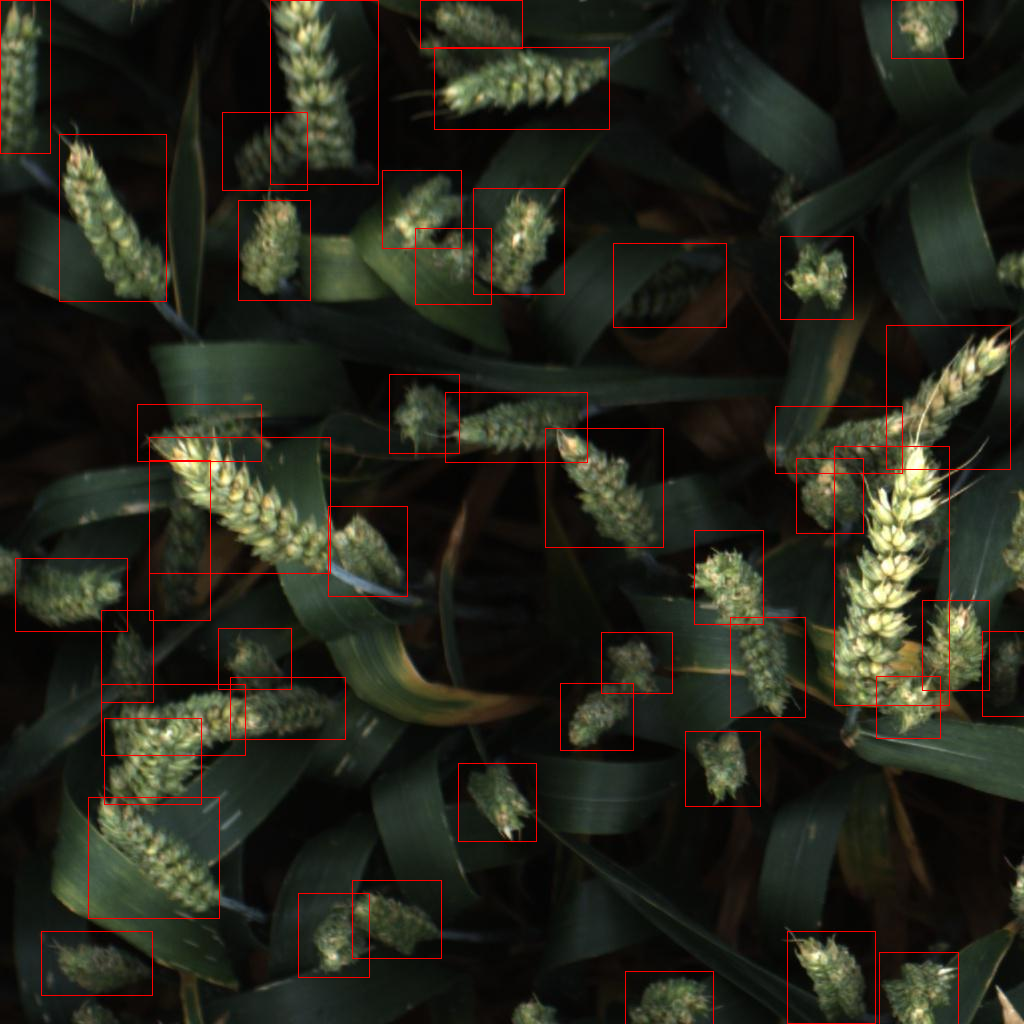

In [31]:
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [32]:
torch.save(model.state_dict(),'model_fastrcnn_resnet50.pth')

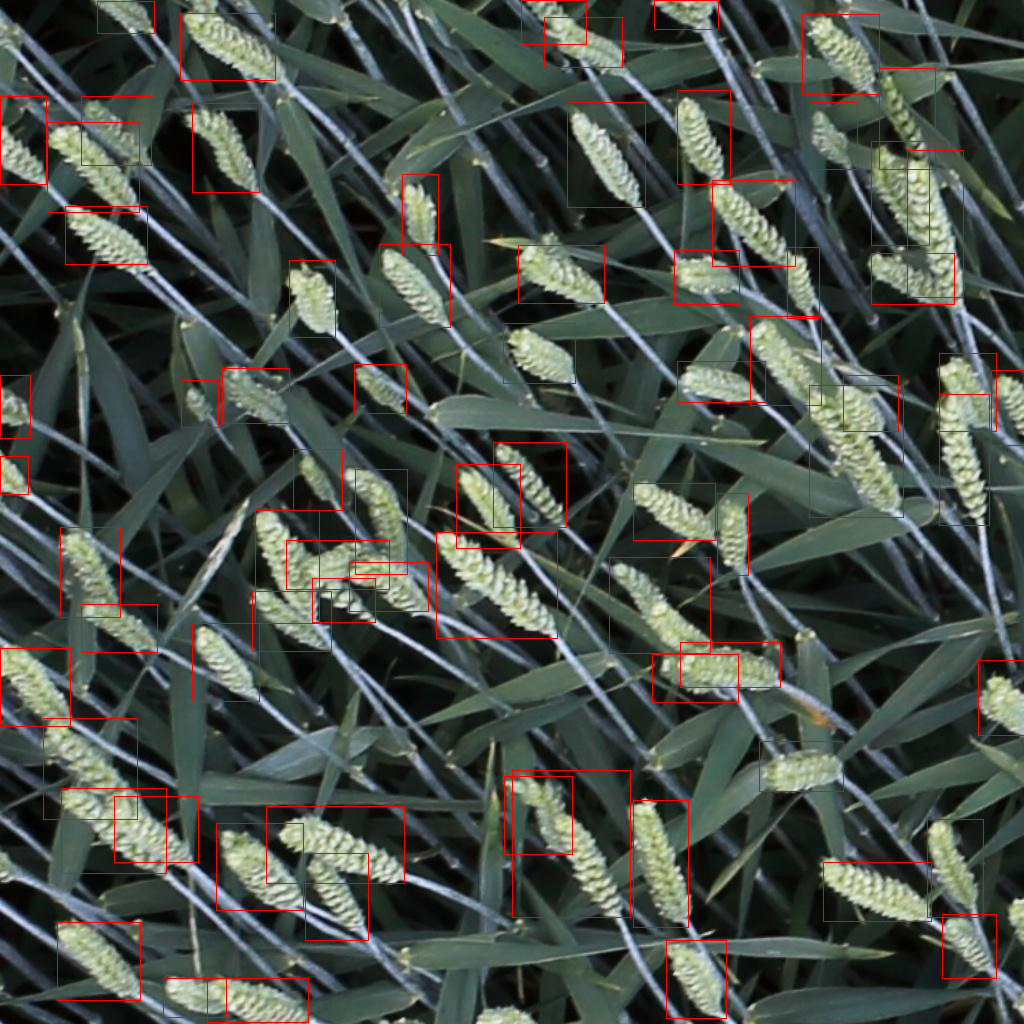

In [34]:
model.eval()
data = iter(val_dl).__next__()

img = data[0][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['label']

output = model([img.to(device)])

out_bbox = output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes:
    draw.rectangle(list(box),fill=None,outline='red')
vsample

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=False)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one (adjusting for the number of classes)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

# Specify the number of classes (1 class + background)
num_classes = 2

# Create a model instance
model2 = create_model(num_classes)

# Load the saved model state dictionary
model2.load_state_dict(torch.load('/mnt/A42AC5272AC4F778/Object_Detection/model_fastrcnn_resnet50.pth'))

# Move the model to the specified device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

# Now the model is ready to be used for inference or further training

/home/shubham/anaconda3/envs/emo/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/shubham/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%
/tmp/ipykernel_65951/600066366.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbi

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

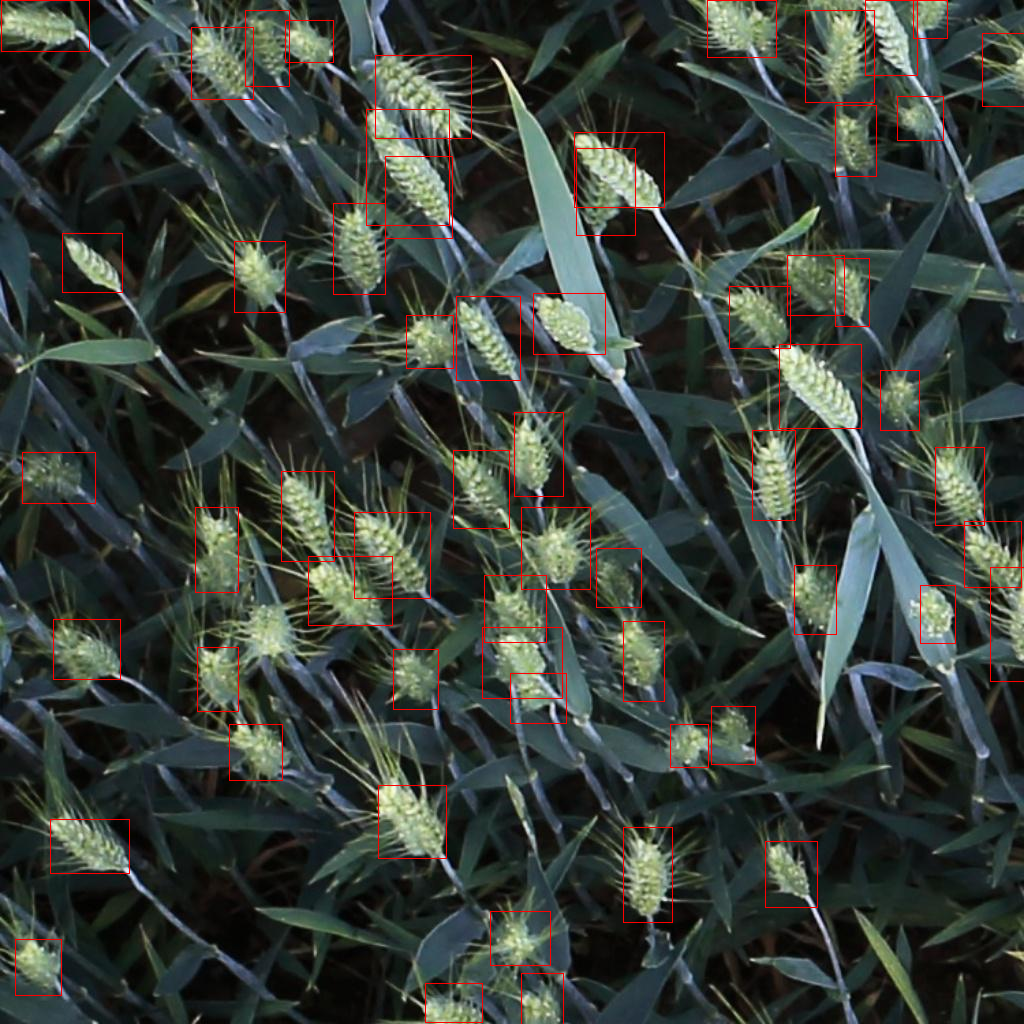

In [36]:
model2.eval()
data = iter(val_dl).__next__()

img= data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['label']

output = model([img.to(device)])

out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

keep = torchvision.ops.nms(out_bbox,out_scores,0.45)

out_bbox.shape , keep.shape
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')

vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)
for box in boxes :
    draw.rectangle(list(box),fill=None,outline='red')
vsample